# Part 2: Classification

In [1]:
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 100

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import interp

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

import timeit

Using TensorFlow backend.


In [2]:
# read data created in Part 1
data = pd.read_csv("preprocessed2.csv")

In [3]:
# set random seed
rs = 5

In [4]:
# separate features from labels
data_X, data_y = (
    data.loc[:, data.columns != "loan_status"],
    data.loc[:, data.columns == "loan_status"],
)
X, y = data_X.values, data_y.values.ravel()

To compare between the models, we will be using $n$-fold cross-validation to calculate average ROC curve and AUC. For this purpose we created a function which takes as input data and scikit-learn classifier, performs $n$-fold cross-validation, plotting resulting ROC with each fold and saves the mean ROC of each classifier for later comparison. As some classifiers are notorious for performing badly on imbalanced data, we have an optional argument indicating whether the majority class should be undersampled before fitting.

In [5]:
rus = RandomUnderSampler(random_state=rs)
summary_roc = {}


def cv_mean_roc(X, y, classifier, name, undersample_data, n_splits=5):

    cv = StratifiedKFold(n_splits=n_splits)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    start_time = timeit.default_timer()

    for train, test in cv.split(X, y):
        if undersample_data:
            X_b, y_b = rus.fit_resample(X[train], y[train])
            probas_ = classifier.fit(X_b, y_b).predict_proba(X[test])
        else:
            probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label="ROC fold %d (AUC = %0.2f)" % (i, roc_auc),
        )

        i += 1
    elapsed = timeit.default_timer() - start_time

    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Chance",
        alpha=0.8,
    )

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(name + " ROC")
    plt.legend(loc="lower right")
    plt.show()

    summary_roc[name] = (mean_fpr, mean_tpr, mean_auc, std_auc, elapsed)

## Decision tree

Since decision tree is one of the simplest classifiers we will use it as a benchmark for more elaborate ones. We need to undersample data as trees are known to favour the majority class on imbalanced data sets. Setting maximal depth prevents it from overfitting training data and its value was chosen experimentally.

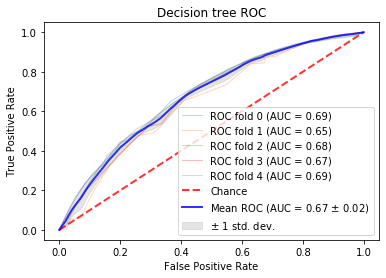

In [6]:
tree = DecisionTreeClassifier(random_state=rs, max_depth=5)
cv_mean_roc(X, y, tree, "Decision tree", undersample_data=True)

## Logistic regression

Another baseline model is logistic regression, it works under assumption that the log-odds are a linear function of the predictors. We use $L2$ penalty to prevent overfitting and do not need to undersample data here because we can take imbalance into account by increasing the penalty for misclassification of the minority class. Mean AUC is same as for the decision tree, but it has smaller standard error.

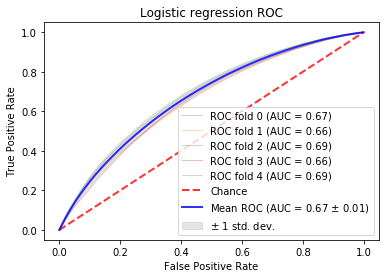

In [7]:
logreg = LogisticRegression(
    class_weight="balanced",
    random_state=rs,
    verbose=0,
    solver="lbfgs",
    max_iter=1000,
)

pipe = Pipeline([("scaler", StandardScaler()), ("logreg", logreg)])

cv_mean_roc(X, y, pipe, "Logistic regression", undersample_data=False)

## Random forest 

As mentioned earlier, plain vanilla decision trees suffer from high bias. One way of overcoming this issue is training an ensemble of trees each using only a random subset of features for its splits. This strategy works on our data, as mean AUC for random forest presents 2pp improvement over single tree also with smaller mean squared error.

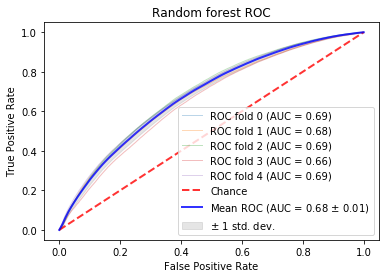

In [8]:
rf = RandomForestClassifier(
    n_estimators=256, random_state=rs, verbose=0, n_jobs=-1, max_depth=8
)
cv_mean_roc(X, y, rf, "Random forest", undersample_data=True)

## Finding the best predictors

We can get some insight into the problem by investigating feature importances assigned by random forest. We can see that some of them have noticably higher importance than the rest.

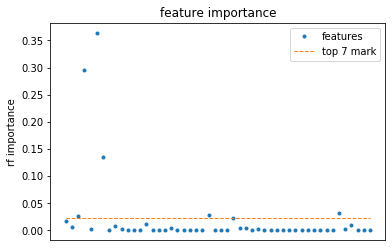

In [9]:
importances = rf.feature_importances_

fig, ax = plt.subplots()
importances.argsort()[-7:][::-1]
ax.plot(importances, ".", label="features")
ax.plot(
    0 * importances + importances[importances.argsort()[-7:][::-1]][-1],
    ls="--",
    label="top 7 mark",
    lw=1,
)
ax.set_xticklabels([])
ax.set_xticks([])
plt.title("feature importance")
plt.legend(loc="best")
plt.ylabel("rf importance")
plt.show()

(Un)surprisingly the most important predictor is the subgrade, which essentially is the measure of how risky a loan is. Similarly, risky loans usually have higher interest rates to compensate for the risk of default. 

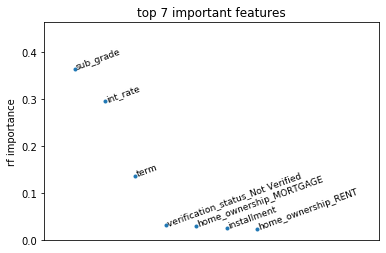

In [10]:
fig, ax = plt.subplots()
labels = list(data_X.columns[importances.argsort()[-7:][::-1]])
ax.plot(importances[importances.argsort()[-7:][::-1]], ".")

for i in range(len(labels)):
    plt.annotate(
        labels[i],
        (i, importances[importances.argsort()[-7:][::-1]][i]),
        fontsize=9,
        rotation=20,
    )
plt.title("top 7 important features")
ax.set_xticklabels([])
ax.set_xticks([])
plt.ylabel("rf importance")
plt.ylim(0, importances[importances.argsort()[-7:][::-1]][0] + 0.1)
plt.xlim(-1, 10)
plt.show()

We will now fit some models only using only 7 most important features .

In [11]:
X_imp = data_X.loc[:, data_X.columns[importances.argsort()[-7:][::-1]]]

## Decision tree II

For decision tree we notice an improvement of 2pp also with decreased standard error.

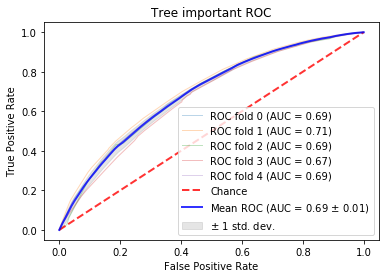

In [12]:
tree = DecisionTreeClassifier(random_state=rs, max_depth=5)
cv_mean_roc(X_imp.values, y, tree, "Tree important", undersample_data=True)

## Logistic regression II

For logistic regression we notice whopping 3pp improvement of mean AUC. It currently beats any previous model. 

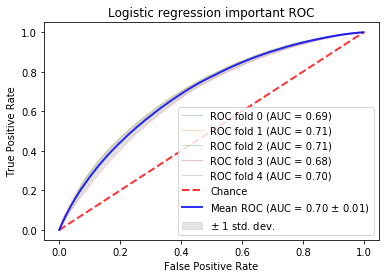

In [13]:
logreg = LogisticRegression(
    class_weight="balanced",
    random_state=rs,
    verbose=0,
    solver="lbfgs",
    max_iter=1000,
)

pipe = Pipeline([("scaler", StandardScaler()), ("logreg", logreg)])

cv_mean_roc(
    X_imp.values,
    y,
    pipe,
    "Logistic regression important",
    undersample_data=False,
)

## Random forest II

Random forest has a modest improvement of 1pp. 

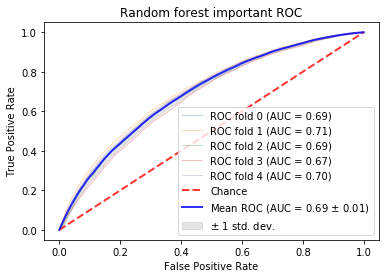

In [14]:
cv_mean_roc(
    X_imp.values, y, rf, "Random forest important", undersample_data=True
)

## Gaussian naive Bayes

Intuitively, stable employment, good credit history and high income are a proxy for creditworthiness. We add them to the important features _sub_grade, int_rate, installment_ also noting that there is a fair chance that to some extent we can approximate them with a normal distribution, hence we can try naive Bayes classifier. It works under an assumption that conditional on the class, features are independent normal random variables. It then finds the optimal parameters for these distributions by maximizing likelihood. It performs very well with rapid training time.

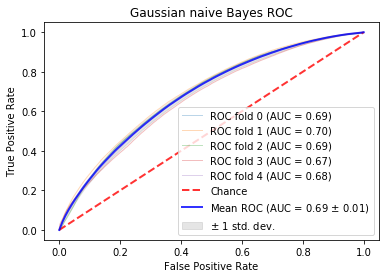

In [15]:
gnb = GaussianNB()
cv_mean_roc(
    data_X.loc[
        :,
        [
            "annual_inc",
            "emp_length",
            "installment",
            "int_rate",
            "sub_grade",
            "yrs_since_last_cr_line",
        ],
    ].values,
    y,
    gnb,
    "Gaussian naive Bayes",
    undersample_data=False,
)

# Part 3: Model comparison and discussion

## Model selection 

ROC curves for the best three models look very similar. Since random forest does not offer significant improvement over a single tree, we will stick to the simpler model and restrict our choice to logistic regression and decision tree. The two classifiers have some pros and cons. Decision tree has an advantage of being easy to explain to wider audience. On the other hand, fitted weights of logistic regression tell us how much a unit increase in the predictor changes the odds of default, which can be a useful input for deciding interest rates and developing better models. For this reason, our model of choice will be logistic regression. 

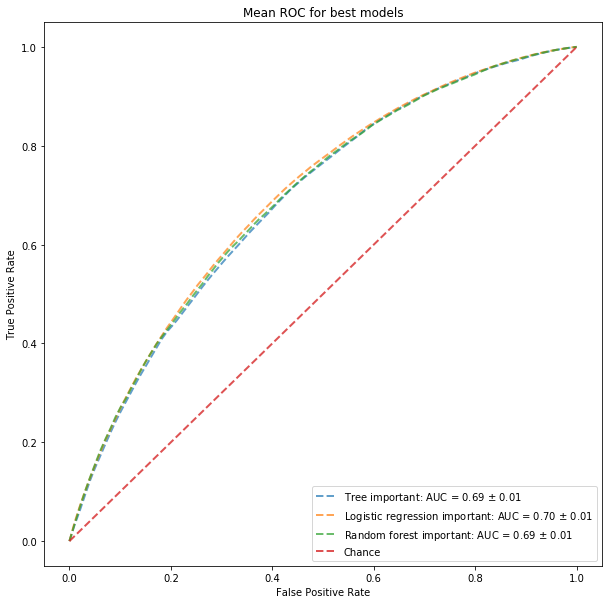

In [16]:
plt.figure(figsize=(10, 10))

for key in summary_roc.keys():

    mean_fpr, mean_tpr, mean_auc, std_auc, elapsed = summary_roc[key]

    if mean_auc >= 0.689:
        plt.plot(
            mean_fpr,
            mean_tpr,
            label=key + r": AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc),
            lw=2,
            alpha=0.7,
            ls="--",
        )

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, label="Chance", alpha=0.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC for best models")


plt.legend(loc="lower right")
plt.show()

Below we can see a plot showing how long it took to train the models.

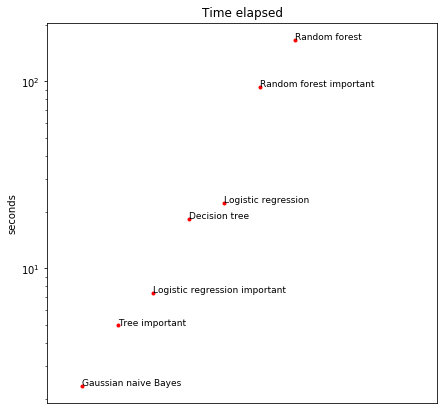

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))

for i, (key, value) in enumerate(
    sorted(summary_roc.items(), key=lambda x: x[1][-1])
):

    mean_fpr, mean_tpr, mean_auc, std_auc, elapsed = value

    ax.semilogy(i, elapsed, ".", color="red")
    plt.annotate(key, (i, elapsed), fontsize=9, rotation=0)


plt.ylabel("seconds")
plt.title("Time elapsed")
ax.set_xticklabels([])
ax.set_xticks([])
plt.xlim(-1, 10)

plt.show()

## Discussion 

AUC is around 0.7, which is interpreted as an estimate of the probability of our classifier ranking a randomly chosen person who defaults higher than a randomly selected person who does not. Given the fact that the models were based almost solely on hard data it is a satisfactory score that can definitely be improved by incorporating domain expertise into the design process. Possible next steps will be aimed at developing a deeper understanding of the dynamics of the platform and the types of borrowers who use it. A review of credit scoring literature may be also beneficial. Furthermore, irrespective of what the final architecture of the model is, we need to establish what is the relative cost of labelling a defaulter as non-defaulter and non-defaulter as defaulter, since depending on this we will adjust our final model to have optimal balance between precision and recall. 

Above we are only reporting the most successful classifiers. Among the ones that were initially considered but eventually not included are:
- Adaboost and RUSBoost (no significant improvement over decision tree)
- Balanced random forest (no improvement over random forest)
- Feedforward neural network (no improvement over logistic regression)
- Linear SVM (poor performance)
- Non-linear SVM (too much data)
- Nystroem kernel approximation with linear SVM (no improvement over simpler methods)